In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [20]:
use_signal = [ i for i, m in enumerate(module.full_signal_list) if m in module.signal_list ]

In [3]:
signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.full_signal_list)])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])

100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


In [4]:
model = eightb.models.feynnet_bkg
(signal + bkg).apply( lambda t : eightb.load_yy_quadh_ranker(t, model.path), report=True )

100%|██████████| 9/9 [00:51<00:00,  5.75s/it]


[None, None, None, None, None, None, None, None, None]

In [5]:
def fully_reconstructed(t):
    h_b_ids = [ t[f'{quark}_signalId'] // 2 for quark in eightb.quarklist ]
    y_h_ids = [ ak.where(h_b1_id == h_b2_id, h_b1_id, -1) // 2 for h_b1_id, h_b2_id in zip(h_b_ids[::2], h_b_ids[1::2]) ]
    y1_id, y2_id = [ ak.where(y_h1_id == y_h2_id, y_h1_id, -1) // 2 for y_h1_id, y_h2_id in zip(y_h_ids[::2], y_h_ids[1::2]) ]
    reco_id = ak.where(y1_id == y2_id, y1_id, -1)
    t.extend(
        reco_id = reco_id
    )
(signal).apply(fully_reconstructed)

[None, None, None, None, None, None, None, None]

In [6]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


x_mean=3.500
x_std=2.291
x_min=0.000
x_max=7.000
y_mean=0.583
y_std=0.131
y_min=0.381
y_max=0.793
x_sum=28.000
y_sum=4.665
area=4.058
ndf=8.000


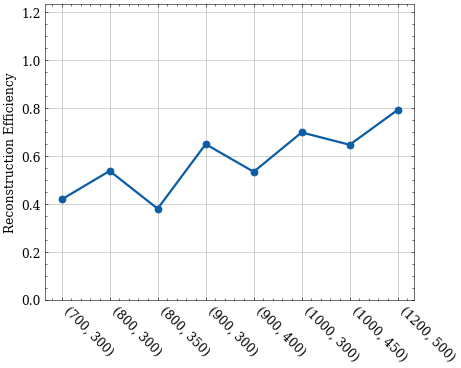

In [18]:
study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,
    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
)

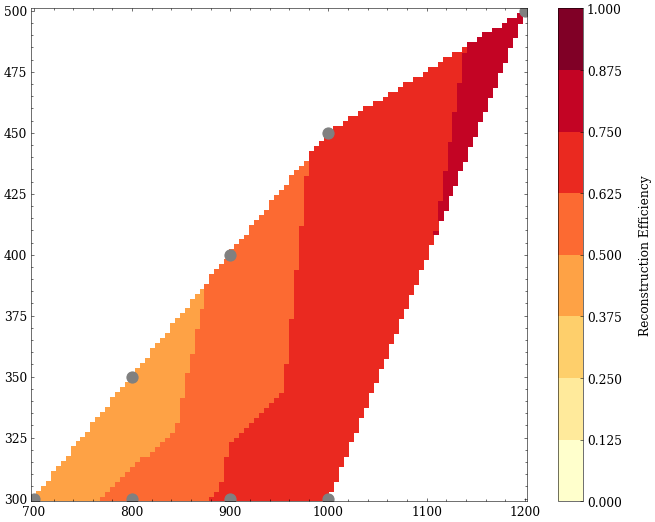

In [12]:
study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    zlim=np.linspace(0,1,9),

)

100%|██████████| 2/2 [00:03<00:00,  1.86s/it]


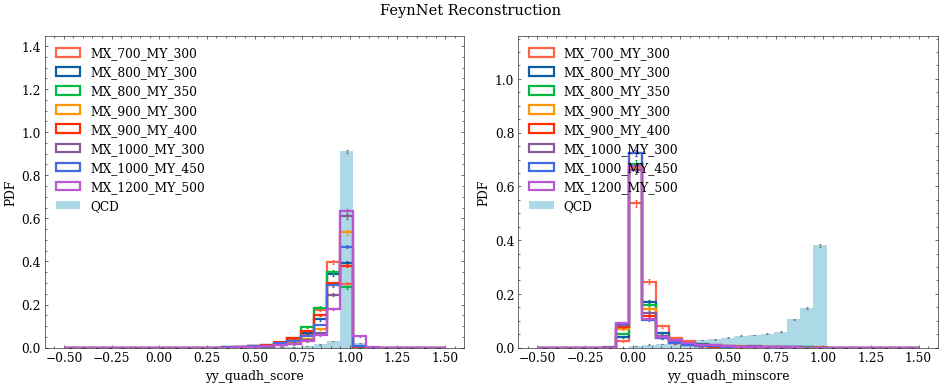

In [8]:
study.quick(
    eightb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [21]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='Leading Y Boson Mass (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='Subleading Y Boson Mass (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Subleading Higgs Boson Mass (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 8/8 [00:01<00:00,  6.61it/s]


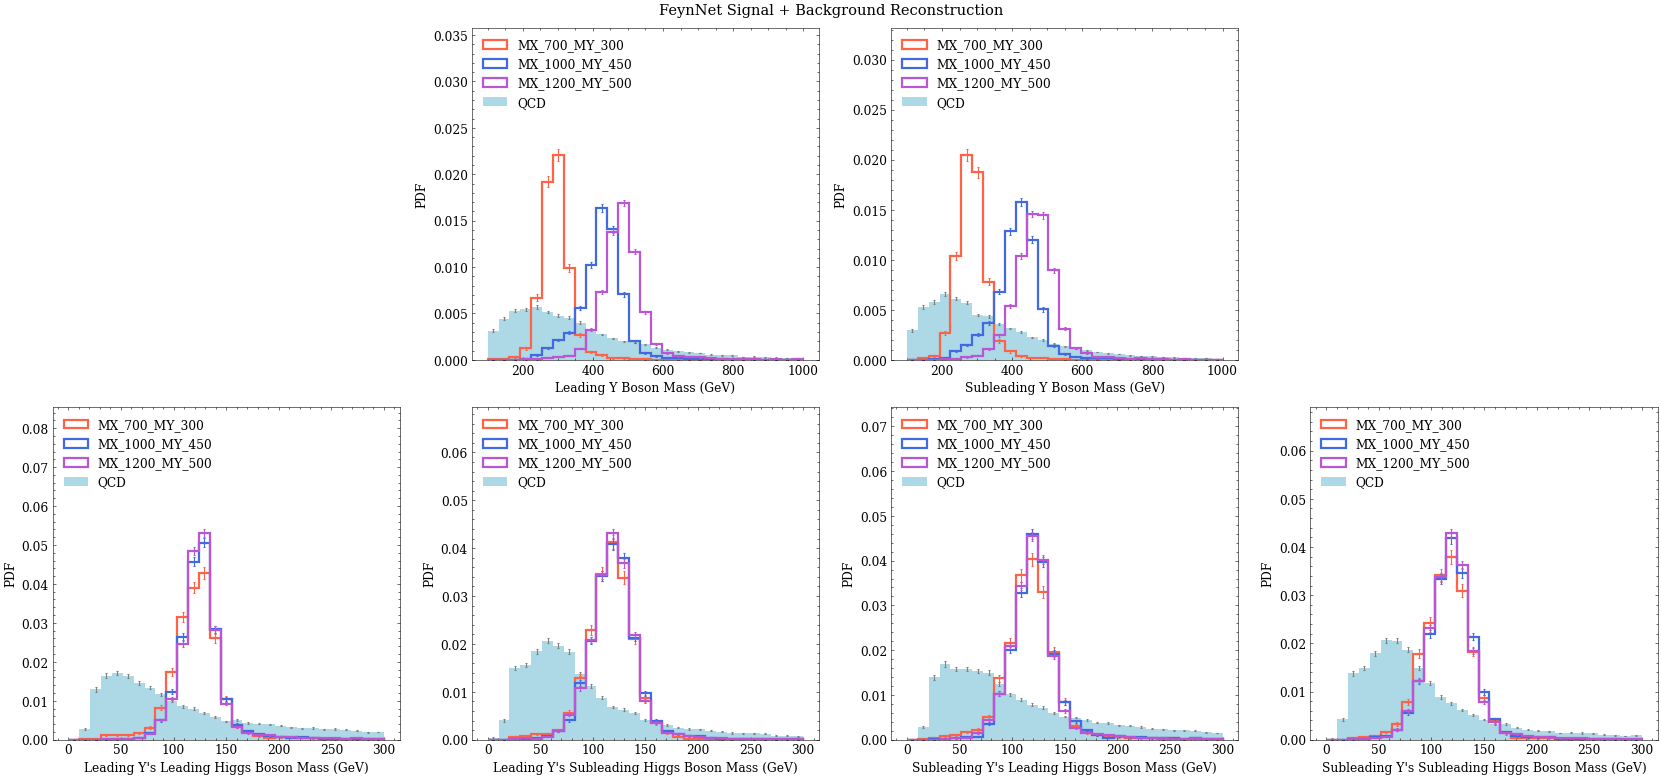

In [23]:
study.quick(
    eightb_signal[use_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal + Background Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 8/8 [00:02<00:00,  3.47it/s]


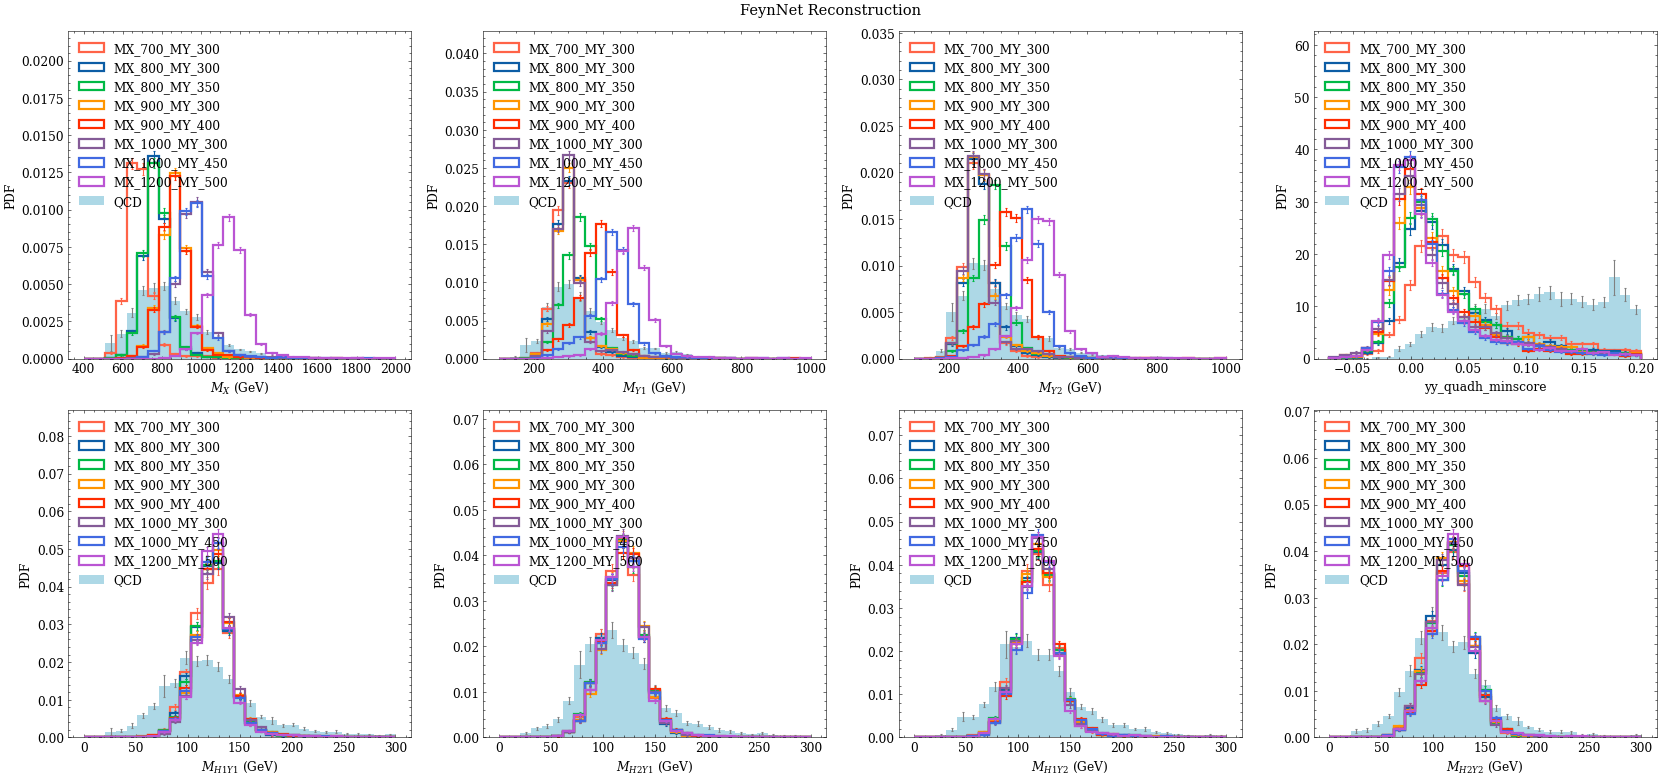

In [11]:
study.quick(
    eightb_signal+bkg,
    masks=lambda t: t.yy_quadh_minscore < 0.2,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m','yy_quadh_minscore','H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Reconstruction',
    lumi=None,
    density=True,
)